# Pipeline Example

In [70]:
import sys
import os
from dotenv import load_dotenv

#1. load environment variables and data

# load environment variables
load_dotenv()

#add working directory to sys path to execute utils/dataset.py
working_dir = os.environ.get("WORKING_DIRECTORY")
sys.path.insert(0, working_dir)

In [71]:
from utils.dataset import get_data 

df = get_data()

Loading data from wines: 8000it [00:00, 21619.76it/s]


In [72]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import numpy as np
from scipy import stats

## Outlier Handling Pipeline

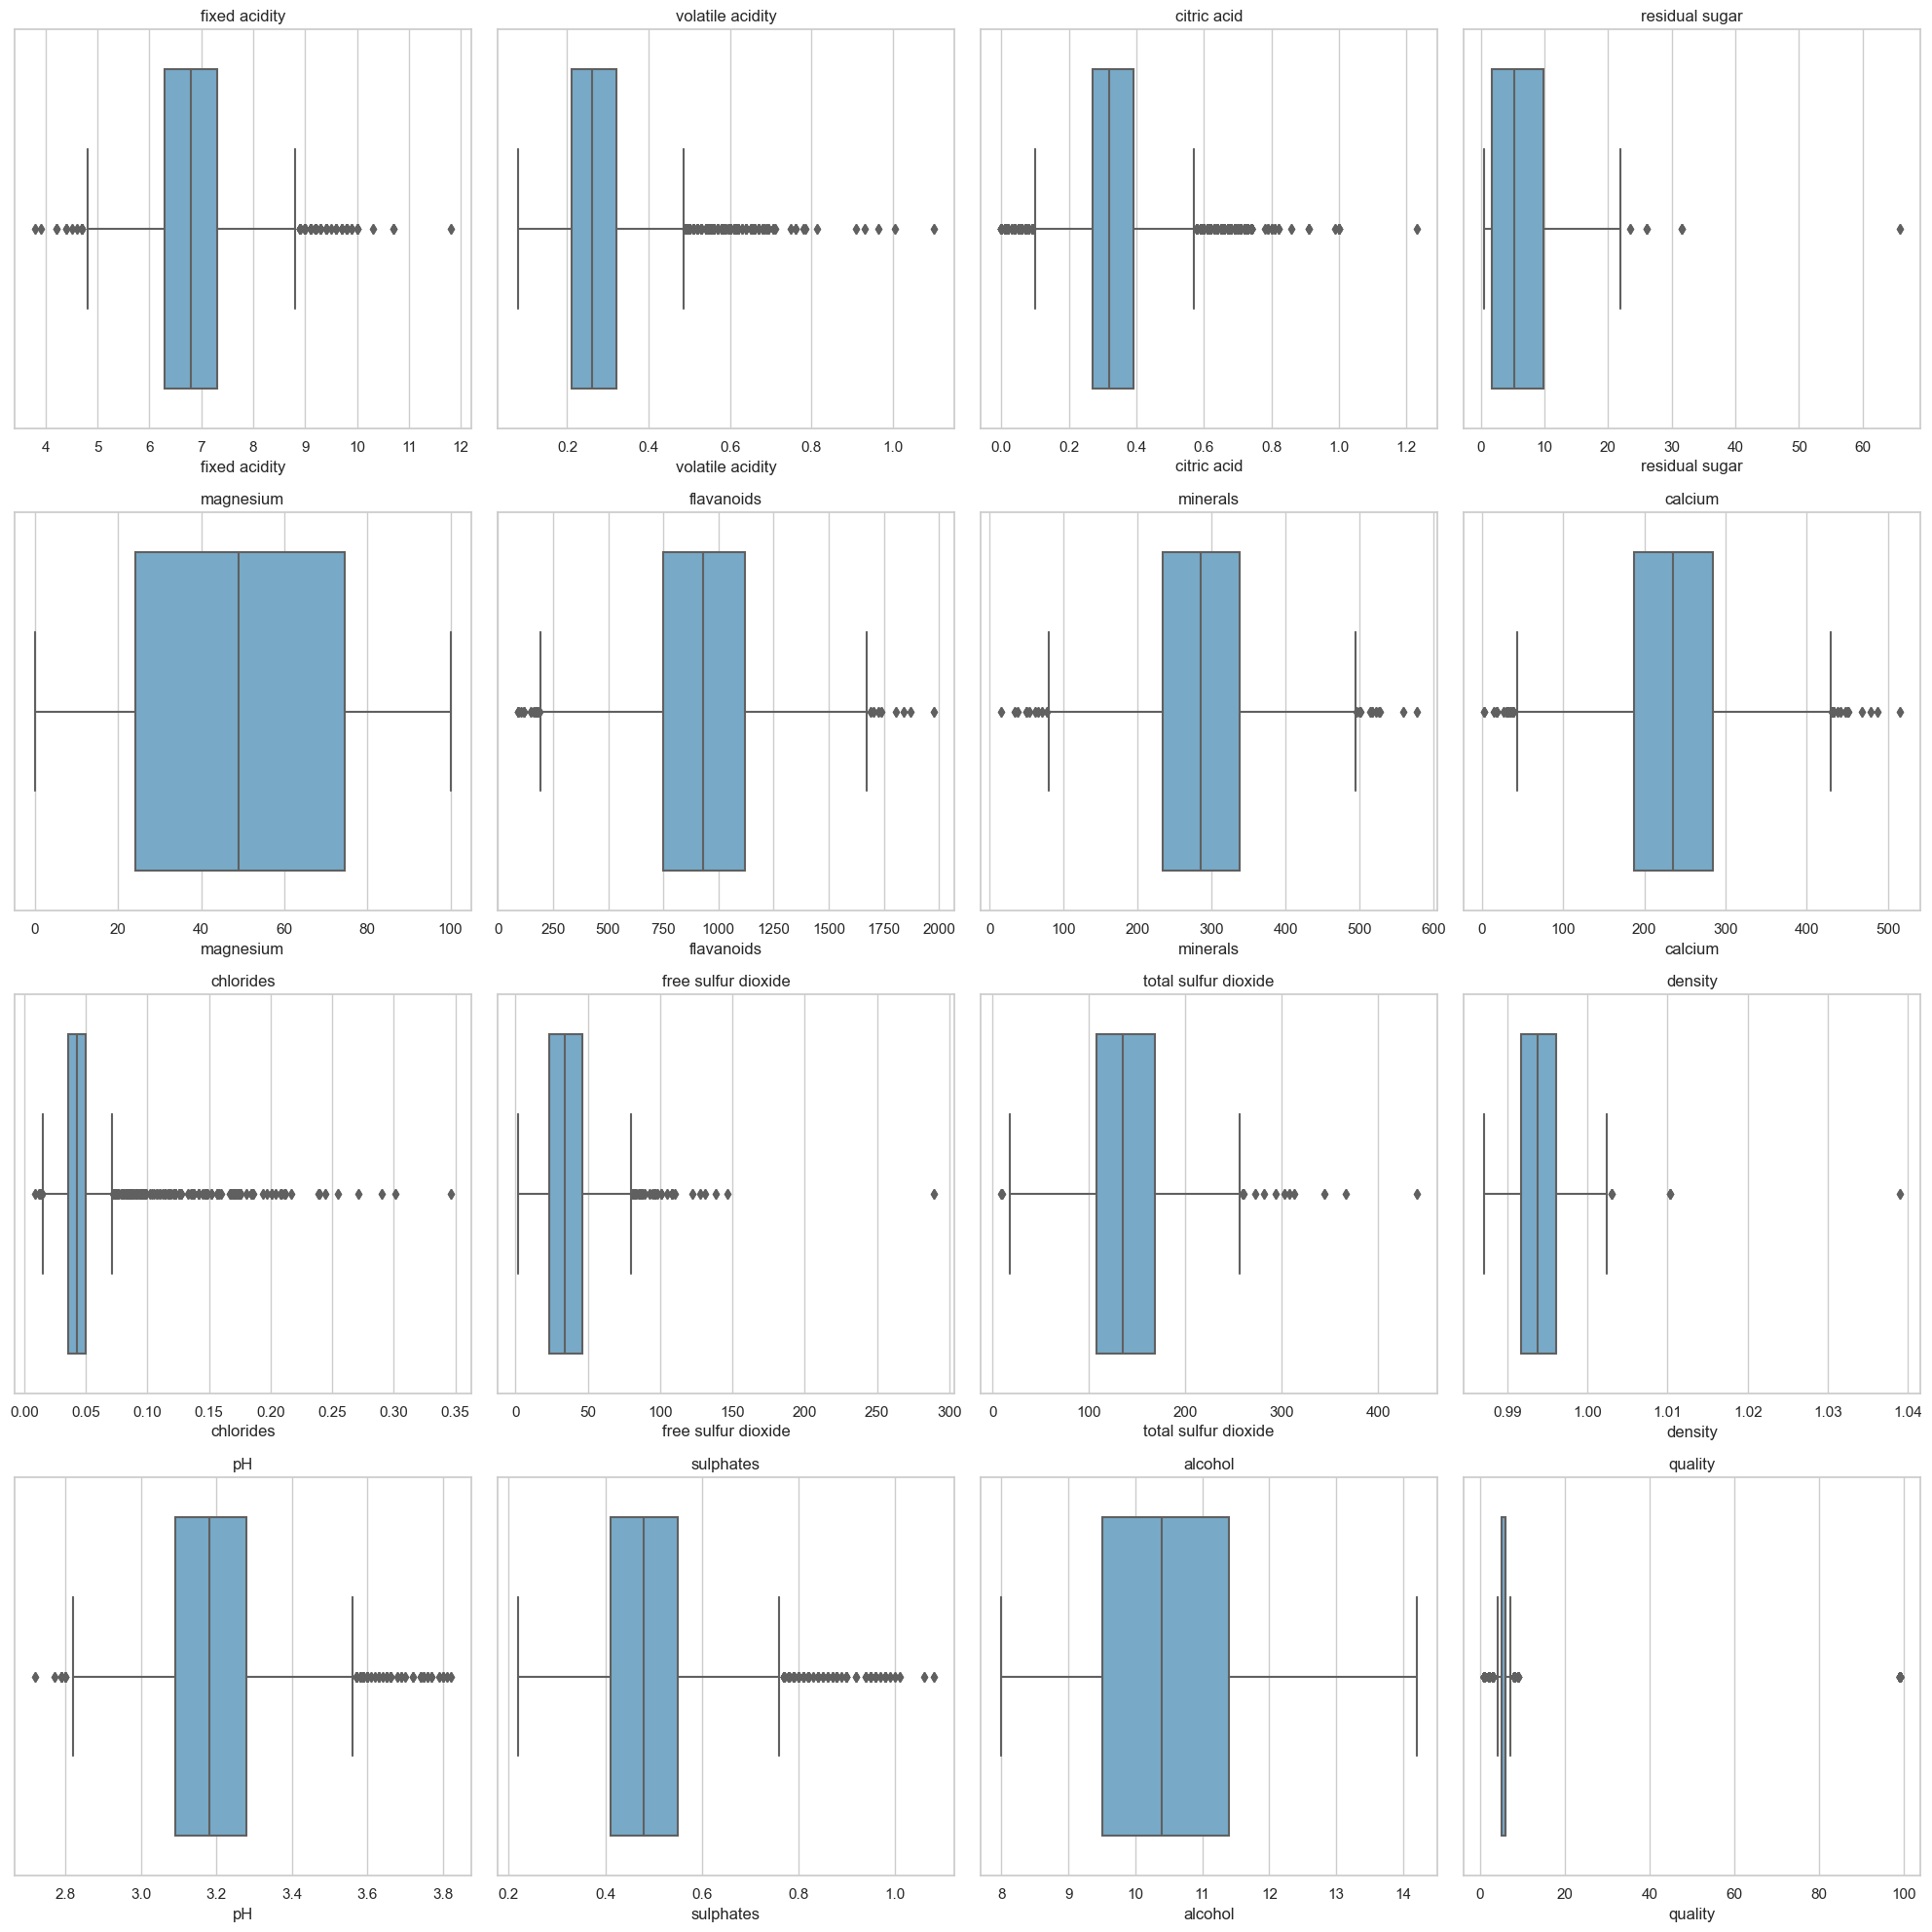

In [73]:
#Check for any outliers in the numerical features (fixed acidity, volatile acidity, citric acid, residual sugar, magnesium, flavanoids, minerals, calcium, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol) using box plots.

#plot one boxplot for each numeric feature but show them in a grid
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

#set the size of the plot
plt.figure(figsize=(20, 20))

#plot a boxplot for each numeric feature ignore warnings
for i, col in enumerate(df.select_dtypes(include=['float64', 'int64']).columns):
    plt.subplot(4, 4, i+1)
    sns.boxplot(x=df[col], palette="Blues")
    plt.title(col)
    plt.tight_layout()
    #remove warnings

### IQR

In [74]:
def remove_outliers_based_on_iqr(data_frame):
    Q1 = data_frame.quantile(0.25)
    Q3 = data_frame.quantile(0.75)
    IQR = Q3 - Q1
    #remove outliers
    df_iqr = data_frame[~((data_frame < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_iqr

/var/folders/qf/_mzt5nz96y12mx5szzg62j480000gn/T/ipykernel_4059/3935625002.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = data_frame.quantile(0.25)
/var/folders/qf/_mzt5nz96y12mx5szzg62j480000gn/T/ipykernel_4059/3935625002.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = data_frame.quantile(0.75)
/var/folders/qf/_mzt5nz96y12mx5szzg62j480000gn/T/ipykernel_4059/3935625002.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_iqr = data_frame[~((data_fr

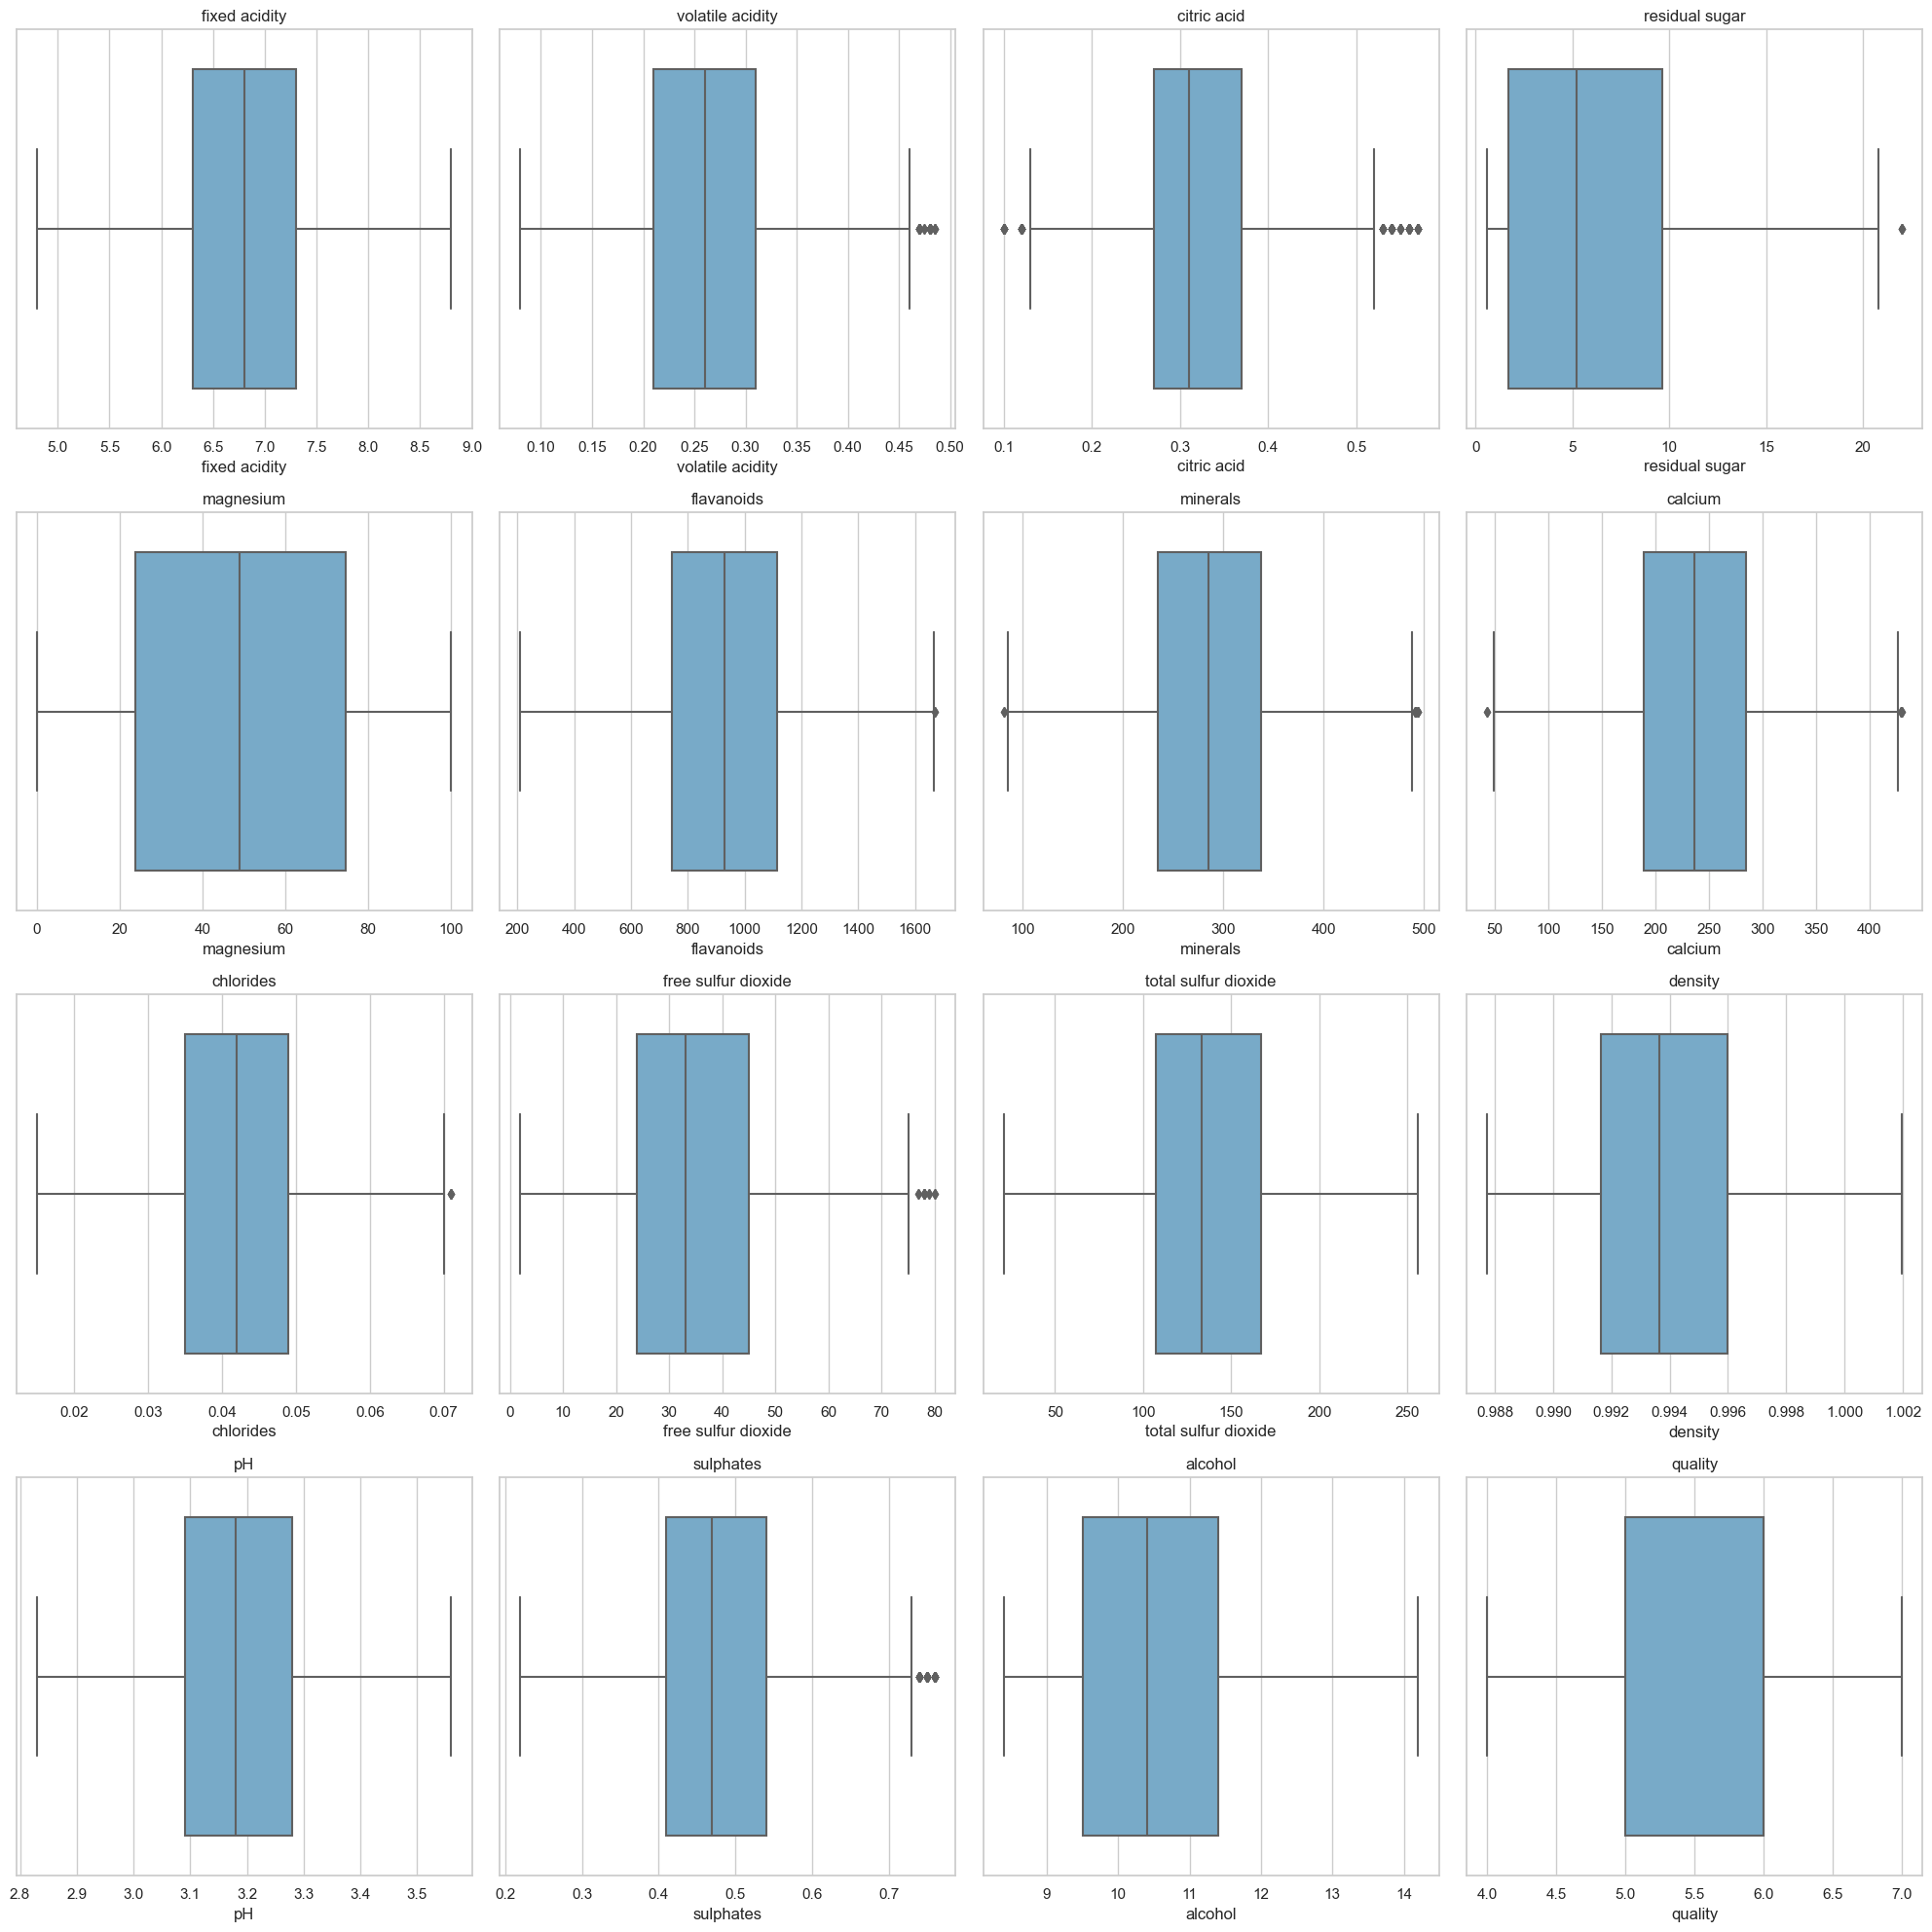

In [75]:
#plot boxplots again to check if outliers have been removed
#set the size of the plot
plt.figure(figsize=(20, 20))
df_iqr = remove_outliers_based_on_iqr(df)

#plot a boxplot for each numeric feature ignore warnings
for i, col in enumerate(df_iqr.select_dtypes(include=['float64', 'int64']).columns):
    plt.subplot(4, 4, i+1)
    sns.boxplot(x=df_iqr[col], palette="Blues")
    plt.title(col)
    plt.tight_layout()


## Feature Selection

### Using correlation

In [76]:
def feature_selection_based_on_correlation(data_frame):
    corr = data_frame.corr()["quality"].abs().sort_values(ascending=False)
    new_df = data_frame[corr[:11].index]
    return new_df

corr_df = feature_selection_based_on_correlation(df)
corr_df.head()


/var/folders/qf/_mzt5nz96y12mx5szzg62j480000gn/T/ipykernel_4059/3245174248.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data_frame.corr()["quality"].abs().sort_values(ascending=False)


,quality,alcohol,chlorides,density,magnesium,calcium,fixed acidity,total sulfur dioxide,citric acid,minerals,free sulfur dioxide
0,5,9.2,0.048,0.99290,76.729301,109.91,5.8,98.0,0.49,186.639301,21.0
1,6,11.1,0.039,0.99163,4.795712,247.08,6.6,68.0,0.32,251.875712,15.0
2,7,12.6,0.035,0.98949,85.193710,219.51,6.7,123.0,0.34,304.703710,45.0
3,6,9.1,0.045,1.00014,11.976525,225.61,8.3,253.0,0.27,237.586525,48.0
4,6,10.0,0.041,0.99508,5.599673,89.80,7.5,150.0,0.19,95.399673,62.0


### Using Univerate Feature Selection

In [77]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def feature_selection_based_on_univerate(data_frame):
    data_frame = data_frame.dropna()
    X = data_frame.drop("quality", axis=1)
    y = data_frame["quality"]

    #for features we only keep the numeric features
    X = X.select_dtypes(include=["float64", "int64"])
    bestfeatures = SelectKBest(score_func=chi2, k=10)
    fit = bestfeatures.fit(X, y)

    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)

    #concat two dataframes for better visualization
    featureScores = pd.concat([dfcolumns, dfscores], axis=1)
    featureScores.columns = ["Specs", "Score"]  #naming the dataframe columns
    featureScores.nlargest(10, "Score")  #print 10 best features
    df_chi2 = df[featureScores.nlargest(11, "Score")["Specs"].values]
    #add label (quality) to df_chi2
    df_chi2["quality"] = data_frame["quality"]
    #move label (quality) to first column
    df_chi2 = df_chi2[["quality"] + list(df_chi2.columns[:-1])]

    return df_chi2
univerate_df = feature_selection_based_on_univerate(df)
univerate_df.head()

/var/folders/qf/_mzt5nz96y12mx5szzg62j480000gn/T/ipykernel_4059/1966959436.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chi2["quality"] = data_frame["quality"]


,quality,total sulfur dioxide,free sulfur dioxide,flavanoids,residual sugar,minerals,magnesium,calcium,alcohol,volatile acidity,fixed acidity,chlorides
0,5.0,98.0,21.0,894.94,1.1,186.639301,76.729301,109.91,9.2,0.15,5.8,0.048
1,6.0,68.0,15.0,1160.95,5.6,251.875712,4.795712,247.08,11.1,0.25,6.6,0.039
2,7.0,123.0,45.0,789.82,1.5,304.703710,85.193710,219.51,12.6,0.21,6.7,0.035
3,6.0,253.0,48.0,777.86,17.5,237.586525,11.976525,225.61,9.1,0.28,8.3,0.045
4,6.0,150.0,62.0,785.72,6.9,95.399673,5.599673,89.80,10.0,0.42,7.5,0.041


## Build Pipelines

Da wir nun jeden Schritt, den wir an den Daten vorgenommen haben, in eine Funktion gepackt haben, können wir diese Funktion nun auch in der Pipeline nutzen.

In [78]:
# Hier verpacken wir unsere Funktionen in die FunctionTransformer von scikit-learn, damit die Funktionen auch in einem Pipeline-Objekt verwendet werden können.
tf_remove_outliers_based_on_iqr = FunctionTransformer(remove_outliers_based_on_iqr)
tf_select_features_based_on_correlation = FunctionTransformer(feature_selection_based_on_correlation)
tf_select_features_based_on_univerate = FunctionTransformer(feature_selection_based_on_univerate)

# Hier erstellen wir zwei Pipelines, die jeweils die Funktionen ausführen, die wir in den vorherigen Schritten definiert haben.
outlier_iqr_correlation_pipeline = Pipeline([("remove_outliers", tf_remove_outliers_based_on_iqr), ("feature_selection_correlation", tf_select_features_based_on_correlation)])
outlier_iqr_univerate_pipeline = Pipeline([("remove_outliers", tf_remove_outliers_based_on_iqr), ("feature_selection_univerate", tf_select_features_based_on_univerate)])

# Hier führen wir die Pipelines aus.
pipeline_1 = outlier_iqr_correlation_pipeline.fit(df)
pipeline_2 = outlier_iqr_univerate_pipeline.fit(df)

/var/folders/qf/_mzt5nz96y12mx5szzg62j480000gn/T/ipykernel_4059/3935625002.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = data_frame.quantile(0.25)
/var/folders/qf/_mzt5nz96y12mx5szzg62j480000gn/T/ipykernel_4059/3935625002.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = data_frame.quantile(0.75)
/var/folders/qf/_mzt5nz96y12mx5szzg62j480000gn/T/ipykernel_4059/3935625002.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_iqr = data_frame[~((data_fr

In [81]:
# Hier transformieren wir die Daten mit der ersten Pipeline (Outlier rausnehmen und dann FS nach Correlation). 
pipeline_1_output = pipeline_1.transform(df)
pipeline_1_output.describe()

/var/folders/qf/_mzt5nz96y12mx5szzg62j480000gn/T/ipykernel_4059/3935625002.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = data_frame.quantile(0.25)
/var/folders/qf/_mzt5nz96y12mx5szzg62j480000gn/T/ipykernel_4059/3935625002.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = data_frame.quantile(0.75)
/var/folders/qf/_mzt5nz96y12mx5szzg62j480000gn/T/ipykernel_4059/3935625002.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_iqr = data_frame[~((data_fr

,quality,alcohol,density,chlorides,total sulfur dioxide,volatile acidity,residual sugar,pH,fixed acidity,magnesium,minerals
count,5964.000000,5964.000000,5964.000000,5956.000000,5956.000000,5964.000000,5956.000000,5964.000000,5964.000000,5956.000000,5956.000000
mean,5.864520,10.530675,0.993932,0.042493,137.735729,0.264772,6.394124,3.186419,6.811704,49.313171,286.060551
std,0.752717,1.192591,0.002884,0.009855,41.442619,0.075731,4.975383,0.136764,0.738325,29.104070,73.951109
min,4.000000,8.400000,0.987740,0.015000,21.000000,0.080000,0.600000,2.830000,4.800000,0.035118,81.374000
25%,5.000000,9.500000,0.991640,0.035000,107.000000,0.210000,1.700000,3.090000,6.300000,23.786439,234.905929
50%,6.000000,10.400000,0.993650,0.042000,133.000000,0.260000,5.200000,3.180000,6.800000,48.968755,285.639212
75%,6.000000,11.400000,0.996000,0.049000,167.000000,0.310000,9.650000,3.280000,7.300000,74.625707,337.235564
max,7.000000,14.200000,1.001960,0.071000,256.000000,0.485000,22.000000,3.560000,8.800000,99.998181,494.044387


In [82]:
# Hier transformieren wir die Daten mit der ersten Pipeline (Outlier rausnehmen und dann FS nach Multivariater Analyse). 
pipeline_2_output = pipeline_2.transform(df)
pipeline_2_output.describe()

/var/folders/qf/_mzt5nz96y12mx5szzg62j480000gn/T/ipykernel_4059/3935625002.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = data_frame.quantile(0.25)
/var/folders/qf/_mzt5nz96y12mx5szzg62j480000gn/T/ipykernel_4059/3935625002.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = data_frame.quantile(0.75)
/var/folders/qf/_mzt5nz96y12mx5szzg62j480000gn/T/ipykernel_4059/3935625002.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_iqr = data_frame[~((data_fr

,quality,total sulfur dioxide,free sulfur dioxide,residual sugar,minerals,flavanoids,calcium,magnesium,alcohol,volatile acidity,fixed acidity,chlorides
count,5952.000000,7992.000000,7992.000000,7992.000000,7992.000000,7992.000000,7992.000000,7992.000000,8000.000000,8000.000000,8000.000000,7992.000000
mean,5.863575,138.605856,35.191567,6.406219,285.652011,934.437470,236.327565,49.324446,10.507502,0.278486,6.856625,0.045875
std,0.752437,42.704772,17.079654,5.104317,76.881459,270.488368,71.298176,29.086962,1.227373,0.100296,0.841727,0.022340
min,4.000000,9.000000,2.000000,0.600000,16.045445,93.000000,3.000000,0.035118,8.000000,0.080000,3.800000,0.009000
25%,5.000000,108.000000,23.000000,1.700000,233.481329,747.295000,187.495000,24.208416,9.500000,0.210000,6.300000,0.036000
50%,6.000000,135.000000,34.000000,5.200000,284.649716,931.025000,235.215000,49.078666,10.400000,0.260000,6.800000,0.043000
75%,6.000000,168.000000,46.000000,9.900000,337.955361,1118.372500,284.542500,74.582793,11.400000,0.320000,7.300000,0.050000
max,7.000000,440.000000,289.000000,65.800000,576.761262,1974.850000,514.520000,99.998181,14.200000,1.100000,11.800000,0.346000
